# Modeling OU process with an Auto encoder model

In this notebook we checked briefly if the autoencoder trained by OU process can reproduce $\tau$ and $\sigma$. 

In [2]:
import sys
sys.path.append('./IrregularTimeSeriesAutoencoder')
import numpy as np
import pandas as pd
from keras.layers import (Input, Dense, TimeDistributed, LSTM, GRU, Dropout, merge,
                          Flatten, RepeatVector, Recurrent, Bidirectional, SimpleRNN)
from keras.models import Model
import keras_util as ku
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display_png, display_pdf

Using TensorFlow backend.
/Users/tachibana/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [6]:
def encoder(model_input, layer, size, num_layers, drop_frac=0.25, output_size=None,
            bidirectional=False, **parsed_args):
    if output_size is None:
        output_size = size
    encode = model_input
    for i in range(num_layers):
        wrapper = Bidirectional if bidirectional else lambda x: x
        encode = wrapper(layer(size, name='encode_{}'.format(i),
                               return_sequences=(i < num_layers - 1)))(encode)
        if drop_frac > 0.0:
            encode = Dropout(drop_frac, name='drop_encode_{}'.format(i))(encode)
    encode = Dense(output_size, activation='linear', name='encoding')(encode)
    return encode

def decoder(encode, layer, n_step, size, num_layers, drop_frac=0.25, aux_input=None,
            bidirectional=False, **parsed_args):
    
    decode = RepeatVector(n_step, name='repeat')(encode)
    if aux_input is not None:
        decode = merge([aux_input, decode], mode='concat')

    for i in range(num_layers):
        if drop_frac > 0.0 and i > 0:  # skip these for first layer for symmetry
            decode = Dropout(drop_frac, name='drop_decode_{}'.format(i))(decode)
        wrapper = Bidirectional if bidirectional else lambda x: x
        decode = wrapper(layer(size, name='decode_{}'.format(i),
                               return_sequences=True))(decode)

    decode = TimeDistributed(Dense(1, activation='linear'), name='time_dist')(decode)
    return decode

import subprocess
def load_lcs(pass_to_lc_dir):
    command = 'ls ' + str(pass_to_lc_dir)
    lc_files = subprocess.run(command, stdout=subprocess.PIPE, shell=True).stdout.decode('utf-8').split('\n')
    del lc_files[len(lc_files)-1]
    print('Loading %d data:'%len(lc_files))
    X = [np.r_[np.array(pd.read_csv('./lcs/'+str(lc_files[i]), header=None, sep=' ')).tolist()] for i in range(len(lc_files))]
    print('Finish.')
    return  X

def preprocess(X_raw, m_max=np.inf):
    X = X_raw.copy()
    wrong_units =  np.all(np.isnan(X[:, :, 1])) | (np.nanmax(X[:, :, 1], axis=1) > m_max)
    X = X[~wrong_units, :, :]
    X[:, :, 0] = ku.times_to_lags(X[:, :, 0])
    means = np.atleast_2d(np.nanmean(X[:, :, 1], axis=1)).T
    X[:, :, 1] -= means
    scales = np.atleast_2d(np.nanstd(X[:, :, 1], axis=1)).T
    X[:, :, 1] /= scales
    errors = X[:, :, 2] / scales
    X = X[:, :, :2]
    return X, means, scales, errors, wrong_units

In [4]:
X_list = load_lcs('./lcs/')

Loading 4227 data:
Finish.


In [5]:
from keras.preprocessing.sequence import pad_sequences
X_raw = pad_sequences(X_list, value=np.nan, dtype='float', padding='post')

In [7]:
X, means, scales, errors, wrong_units = preprocess(X_raw)

/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide


In [8]:
sample_weight = 1. / errors
sample_weight[np.isnan(sample_weight)] = 0.0
X[np.isnan(X)] = 0.

In [9]:
import pyprocess as pypr

In [10]:
N_sim = len(X)*10
tau_list = 10**(np.random.rand(N_sim)*2+2)
sigma_list = 10**(-np.random.rand(N_sim)*1 - 1.5)
Y = pd.DataFrame()
T = pd.DataFrame()

def make_monk_lc(t, tau, error=np.nanmedian(errors.flatten())):
    mu = 0
    sigma = np.sqrt(1/tau/10)
    theta = 1/tau
    err_to_std = error
    out_tbl = pd.DataFrame()
    oupr = pypr.OU_process(theta=theta, mu=mu, sigma=sigma)
    y = oupr.sample_path(t, N=1)[0]
    y = y - np.mean(y)
    y = y/np.std(y)
    y = y + np.random.randn(len(y))#*err_to_std
    out_tbl[0] = t
    out_tbl[1] = y
    out_tbl[2] = np.ones(len(t))#*err_to_std
    return(out_tbl)

In [11]:
X_sim_list = [np.r_[np.array(make_monk_lc(X_list[i%len(X_list)][:,0], tau)).tolist()] for i, tau in enumerate(tau_list)]

/Users/tachibana/Documents/AutoEncoder_180312/pyprocess.py:841: RuntimeWarning: overflow encountered in exp
  sigma = np.sqrt(self.sigma**2*(1-np.exp(-2*self.theta*deltas))/(2*self.theta))
/Users/tachibana/Documents/AutoEncoder_180312/pyprocess.py:841: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(self.sigma**2*(1-np.exp(-2*self.theta*deltas))/(2*self.theta))
/Users/tachibana/Documents/AutoEncoder_180312/pyprocess.py:843: RuntimeWarning: overflow encountered in exp
  mu = self.mu + np.exp(-self.theta*delta)*(x-self.mu)
/Users/tachibana/Documents/AutoEncoder_180312/pyprocess.py:843: RuntimeWarning: invalid value encountered in multiply
  mu = self.mu + np.exp(-self.theta*delta)*(x-self.mu)
/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


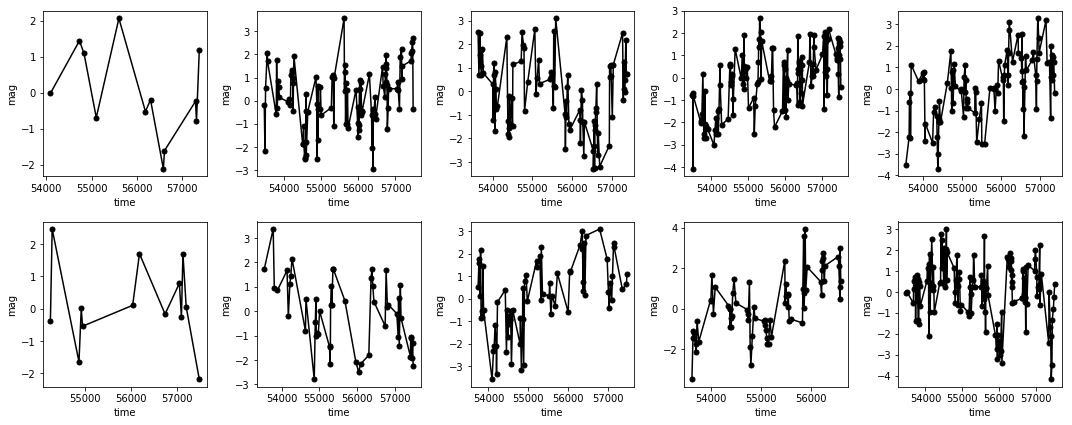

In [17]:
plt.figure(figsize=(15, 6))

for i in range(5):
    plt.subplot(2, 5 ,i+1)
    plt.errorbar(X_sim_list[i][:,0], X_sim_list[i][:,1], fmt='ko-', markersize=5)
    plt.xlabel('time')
    plt.ylabel('mag')
for i in range(5):
    plt.subplot(2, 5 ,i+1+5)
    plt.errorbar(X_sim_list[i+5][:,0], X_sim_list[i+5][:,1], fmt='ko-', markersize=5)
    plt.xlabel('time')
    plt.ylabel('mag')

plt.tight_layout()
plt.show()

In [18]:
X_sim_raw = pad_sequences(X_sim_list, value=np.nan, dtype='float', padding='post')

In [28]:
X_sim, means, scales, errors, wrong_units = preprocess(X_sim_raw)
sample_weight = 1. / errors
sample_weight[np.isnan(sample_weight)] = 0.0
X_sim[np.isnan(X_sim)] = 0.
main_input = Input(shape=(X_sim.shape[1], 2), name='main_input') #(lag, mag)
aux_input = Input(shape=(X_sim.shape[1], 1), name='aux_input') #(lag)
model_input = [main_input, aux_input]

/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: All-NaN slice encountered
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [29]:
encode = encoder(main_input, layer=GRU, size=64, num_layers=5, output_size=16, drop_frac=0.25, bidirectional=True)
decode = decoder(encode, layer=GRU, size=64, num_layers=5,  n_step=X.shape[1], drop_frac=0.25, aux_input=aux_input)
model = Model(model_input, decode)

/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [30]:
lr = 1e-3 #learning rate 

In [31]:
from keras.optimizers import Adam
import os

optimizer = Adam(lr=lr)

log_dir = os.path.join(os.getcwd(), 'keras_logs', 'test')
log_dir += "_ft{:1.0e}".format(lr).replace('e-', 'm')
weights_path = os.path.join(log_dir, 'weights.h5')

print("""log directory: {0} \n
weight pass: {1} """.format(log_dir, weights_path))

log directory: /Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03 

weight pass: /Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03/weights.h5 


In [32]:
model.compile(optimizer=optimizer, loss='mse',  sample_weight_mode='temporal')

In [33]:
import shutil
shutil.rmtree(log_dir, ignore_errors=True)
os.makedirs(log_dir)

In [34]:
from keras.callbacks import (Callback, TensorBoard, EarlyStopping,
                             ModelCheckpoint, CSVLogger, ProgbarLogger)
from keras_tqdm import TQDMCallback
import sys
import csv
from collections import Iterable, OrderedDict
import datetime

class Progbar(TQDMCallback):  # redirect TQDMCallback to stdout
    def __init__(self):
        TQDMCallback.__init__(self)
        self.output_file = sys.stdout
class TimedCSVLogger(CSVLogger):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        def handle_value(k):
            is_zero_dim_ndarray = isinstance(k, np.ndarray) and k.ndim == 0
            if isinstance(k, Iterable) and not is_zero_dim_ndarray:
                return '"[%s]"' % (', '.join(map(str, k)))
            else:
                return k

        if not self.writer:
            self.keys = sorted(logs.keys())

            class CustomDialect(csv.excel):
                delimiter = self.sep

            self.writer = csv.DictWriter(self.csv_file,
                                         fieldnames=['epoch', 'time'] + self.keys,
                                         dialect=CustomDialect)
            if self.append_header:
                self.writer.writeheader()

        row_dict = OrderedDict({'epoch': epoch, 'time': str(datetime.datetime.now())})
        row_dict.update((key, handle_value(logs[key])) for key in self.keys)
        self.writer.writerow(row_dict)
        self.csv_file.flush()
class LogDirLogger(Callback):
    def __init__(self, log_dir):
        self.log_dir = log_dir 

    def on_epoch_begin(self, epoch, logs=None):
        print('\n' + self.log_dir + '\n')

In [39]:
history = model.fit({'main_input': X_sim, 'aux_input': np.delete(X_sim, 1, axis=2)},
                    X_sim[:, :, [1]], 
                    nb_epoch=128, 
                    batch_size=256,
                    sample_weight=sample_weight,
                    callbacks=[Progbar(),
                           TensorBoard(log_dir=log_dir, write_graph=False),
                           TimedCSVLogger(os.path.join(log_dir, 'training.csv'), append=True),
                           ModelCheckpoint(weights_path, save_weights_only=True),
                           LogDirLogger(log_dir)], 
                    verbose=False,
                    validation_split=0.2,
                    validation_data=None)

/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Epoch: 0:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1 - loss: 1.255:  48%|████▊     | 16384/33816 [05:46<06:09, 47.19it/s]


Epoch: 2:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 2 - loss: 1.148:  98%|█████████▊| 33280/33816 [11:40<00:12, 44.05it/s]


Epoch: 3:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 4:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 4 - loss: 1.084:  45%|████▌     | 15360/33816 [05:28<07:05, 43.38it/s]


Epoch: 5:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 5 - loss: 1.063:  19%|█▉        | 6400/33816 [02:15<09:39, 47.35it/s]


Epoch: 6:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 6 - loss: 1.038:  69%|██████▉   | 23296/33816 [08:06<03:49, 45.85it/s]


Epoch: 7:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 8:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 8 - loss: 1.017:  15%|█▌        | 5120/33816 [01:52<10:43, 44.56it/s]


Epoch: 9:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 9 - loss: 1.007:  65%|██████▌   | 22016/33816 [08:02<04:18, 45.58it/s]


Epoch: 10:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 11:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 11 - loss: 0.993:  10%|▉         | 3328/33816 [01:10<10:38, 47.75it/s]


Epoch: 12:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 12 - loss: 1.019:  58%|█████▊    | 19456/33816 [06:51<05:02, 47.43it/s]


Epoch: 13:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 14:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 14 - loss: 1.020:   2%|▏         | 512/33816 [00:11<11:53, 46.70it/s]


Epoch: 15:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 15 - loss: 0.978:  49%|████▉     | 16640/33816 [05:53<06:05, 46.96it/s]


Epoch: 16:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 16 - loss: 0.964:  97%|█████████▋| 32768/33816 [11:40<00:21, 48.52it/s]


Epoch: 17:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 18:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 18 - loss: 0.960:  41%|████      | 13824/33816 [04:50<07:06, 46.84it/s]


Epoch: 19:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 19 - loss: 0.944:  89%|████████▊ | 29952/33816 [10:16<01:17, 49.80it/s]


Epoch: 20:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 21:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 21 - loss: 0.943:  33%|███▎      | 11008/33816 [03:40<07:34, 50.19it/s]


Epoch: 22:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 22 - loss: 0.937:  80%|████████  | 27136/33816 [10:21<02:29, 44.69it/s]


Epoch: 23:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 24:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 24 - loss: 0.928:  24%|██▍       | 8192/33816 [03:06<09:40, 44.16it/s]


Epoch: 24 - loss: 0.933: 100%|█████████▉| 33792/33816 [12:52<00:00, 43.54it/s]


Epoch: 25:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 26:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 26 - loss: 0.923:  44%|████▍     | 14848/33816 [05:36<06:54, 45.72it/s]


Epoch: 27:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 27 - loss: 0.913:  92%|█████████▏| 30976/33816 [11:38<01:04, 43.92it/s]


Epoch: 28:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 29:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 29 - loss: 0.924:  36%|███▌      | 12032/33816 [04:35<08:16, 43.85it/s]


Epoch: 30:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 30 - loss: 0.918:  83%|████████▎ | 28160/33816 [10:36<02:13, 42.40it/s]


Epoch: 31:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 32:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 32 - loss: 0.917:  27%|██▋       | 9216/33816 [03:28<09:04, 45.18it/s]


Epoch: 33:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03




Epoch: 34:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 34 - loss: 0.889:  48%|████▊     | 16128/33816 [06:12<06:52, 42.87it/s]


Epoch: 35:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 35 - loss: 0.889:  95%|█████████▌| 32256/33816 [12:16<00:35, 43.81it/s]


Epoch: 36:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 37:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 37 - loss: 0.888:  39%|███▉      | 13312/33816 [04:59<07:34, 45.07it/s]


Epoch: 38:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 38 - loss: 0.878:  87%|████████▋ | 29440/33816 [10:56<01:36, 45.16it/s]


Epoch: 39:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 40:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 40 - loss: 0.857:  31%|███       | 10496/33816 [03:59<08:46, 44.32it/s]


Epoch: 41:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 41 - loss: 0.856:  79%|███████▊  | 26624/33816 [10:03<02:40, 44.72it/s]


Epoch: 42:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 43:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 43 - loss: 0.906:  23%|██▎       | 7680/33816 [02:47<09:31, 45.72it/s]


Epoch: 44:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 44 - loss: 0.886:  70%|███████   | 23808/33816 [08:59<03:45, 44.48it/s]


Epoch: 45:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 46:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 46 - loss: 0.855:  14%|█▍        | 4864/33816 [01:48<10:40, 45.23it/s]


Epoch: 47:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 47 - loss: 0.848:  62%|██████▏   | 20992/33816 [07:53<04:50, 44.12it/s]


Epoch: 48:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 49:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 49 - loss: 0.852:   6%|▌         | 2048/33816 [00:47<12:13, 43.33it/s]


Epoch: 50:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 50 - loss: 0.845:  54%|█████▎    | 18176/33816 [06:43<05:45, 45.24it/s]


Epoch: 51:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 51 - loss: 0.840: 100%|█████████▉| 33792/33816 [12:36<00:00, 45.07it/s]


Epoch: 52:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 53:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 53 - loss: 0.875:  45%|████▍     | 15104/33816 [05:22<06:35, 47.34it/s]


Epoch: 54:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 54 - loss: 0.827:  92%|█████████▏| 31232/33816 [11:20<00:55, 46.42it/s]


Epoch: 55:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 56:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 56 - loss: 0.829:  36%|███▋      | 12288/33816 [04:24<07:52, 45.52it/s]


Epoch: 57:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 57 - loss: 0.820:  84%|████████▍ | 28416/33816 [10:03<01:56, 46.26it/s]


Epoch: 58:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 59:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 59 - loss: 0.828:  28%|██▊       | 9472/33816 [03:27<09:02, 44.87it/s]


Epoch: 60:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 60 - loss: 0.831:  76%|███████▌  | 25600/33816 [09:13<02:52, 47.72it/s]


Epoch: 61:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 62:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 62 - loss: 0.812:  20%|█▉        | 6656/33816 [02:19<09:36, 47.11it/s]


Epoch: 63:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 63 - loss: 0.805:  67%|██████▋   | 22784/33816 [08:12<04:01, 45.60it/s]


Epoch: 64:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 65:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 65 - loss: 0.824:  11%|█▏        | 3840/33816 [01:23<10:57, 45.58it/s]


Epoch: 66:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 66 - loss: 0.796:  59%|█████▉    | 19968/33816 [07:00<04:54, 47.03it/s]


Epoch: 67:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 68:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 68 - loss: 0.794:   3%|▎         | 1024/33816 [00:22<11:58, 45.62it/s]


Epoch: 69:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 69 - loss: 0.783:  51%|█████     | 17152/33816 [06:15<06:03, 45.82it/s]


Epoch: 70:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 70 - loss: 0.788:  98%|█████████▊| 33280/33816 [12:06<00:11, 46.09it/s]


Epoch: 71:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 72:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 72 - loss: 0.781:  42%|████▏     | 14336/33816 [05:19<07:16, 44.61it/s]


Epoch: 73:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 73 - loss: 0.779:  90%|█████████ | 30464/33816 [11:15<01:16, 43.97it/s]


Epoch: 74:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 75:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 75 - loss: 0.794:  34%|███▍      | 11520/33816 [04:06<07:54, 46.99it/s]


Epoch: 76:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 76 - loss: 0.775:  82%|████████▏ | 27648/33816 [10:12<02:11, 46.85it/s]


Epoch: 77:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 78:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 78 - loss: 0.765:  26%|██▌       | 8704/33816 [03:10<09:11, 45.57it/s]


Epoch: 79:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 79 - loss: 0.763:  73%|███████▎  | 24576/33816 [08:17<02:58, 51.72it/s]


Epoch: 80:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 81:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 81 - loss: 0.768:  17%|█▋        | 5632/33816 [02:03<10:01, 46.85it/s]


Epoch: 82:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 82 - loss: 0.759:  64%|██████▍   | 21760/33816 [07:34<04:22, 45.97it/s]


Epoch: 83:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 84:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 84 - loss: 0.755:   8%|▊         | 2816/33816 [00:56<10:21, 49.91it/s]


Epoch: 85:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 85 - loss: 0.751:  56%|█████▌    | 18944/33816 [06:19<04:55, 50.30it/s]


Epoch: 86:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 87:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03




Epoch: 88:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 88 - loss: 0.754:  48%|████▊     | 16128/33816 [05:22<05:48, 50.77it/s]


Epoch: 89:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 89 - loss: 0.743:  95%|█████████▌| 32256/33816 [10:46<00:31, 49.99it/s]


Epoch: 90:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 91:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 91 - loss: 0.742:  39%|███▉      | 13312/33816 [04:48<07:06, 48.10it/s]


Epoch: 92:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 92 - loss: 0.742:  87%|████████▋ | 29440/33816 [10:05<01:28, 49.30it/s]


Epoch: 93:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 94:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 94 - loss: 0.740:  31%|███       | 10496/33816 [03:31<07:55, 49.04it/s]


Epoch: 95:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 95 - loss: 0.734:  79%|███████▊  | 26624/33816 [09:07<02:36, 46.09it/s]


Epoch: 96:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 97:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 97 - loss: 0.742:  23%|██▎       | 7680/33816 [02:38<08:50, 49.24it/s]


Epoch: 98:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 98 - loss: 0.733:  70%|███████   | 23808/33816 [08:10<03:23, 49.16it/s]


Epoch: 99:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 100:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 100 - loss: 0.731:  14%|█▍        | 4864/33816 [01:36<09:34, 50.35it/s]


Epoch: 101:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 101 - loss: 0.727:  60%|█████▉    | 20224/33816 [07:24<05:08, 44.09it/s]


Epoch: 102:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 103:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 103 - loss: 0.734:   2%|▏         | 768/33816 [00:16<12:05, 45.54it/s]


Epoch: 104:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 104 - loss: 0.726:  48%|████▊     | 16384/33816 [06:01<06:27, 45.04it/s]


Epoch: 105:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 105 - loss: 0.725:  94%|█████████▍| 31744/33816 [11:37<00:44, 46.45it/s]


Epoch: 106:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 107:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 107 - loss: 0.728:  36%|███▋      | 12288/33816 [04:29<07:56, 45.19it/s]


Epoch: 108:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 108 - loss: 0.723:  83%|████████▎ | 27904/33816 [10:27<02:07, 46.27it/s]


Epoch: 109:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 110:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 110 - loss: 0.722:  25%|██▍       | 8448/33816 [03:10<09:30, 44.49it/s]


Epoch: 111:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 111 - loss: 0.721:  70%|███████   | 23808/33816 [08:52<03:42, 44.93it/s]


Epoch: 112:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 113:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 113 - loss: 0.717:  13%|█▎        | 4352/33816 [01:38<11:03, 44.41it/s]


Epoch: 114:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 114 - loss: 0.720:  58%|█████▊    | 19712/33816 [07:21<05:06, 46.00it/s]


Epoch: 115:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 116:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 116 - loss: 0.719:   1%|          | 256/33816 [00:05<11:50, 47.22it/s]


Epoch: 117:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 117 - loss: 0.718:  47%|████▋     | 15872/33816 [05:51<06:51, 43.66it/s]


Epoch: 118:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 118 - loss: 0.715:  92%|█████████▏| 31232/33816 [11:31<00:59, 43.16it/s]


Epoch: 119:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 120:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 120 - loss: 0.729:  35%|███▍      | 11776/33816 [04:20<07:57, 46.13it/s]


Epoch: 121:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 121 - loss: 0.715:  81%|████████  | 27392/33816 [10:02<02:22, 45.14it/s]


Epoch: 122:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 123:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 123 - loss: 0.721:  23%|██▎       | 7936/33816 [02:57<09:39, 44.62it/s]


Epoch: 124:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 124 - loss: 0.712:  69%|██████▉   | 23296/33816 [07:42<03:33, 49.23it/s]


Epoch: 125:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 126:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 126 - loss: 0.718:  11%|█▏        | 3840/33816 [01:18<10:25, 47.89it/s]


Epoch: 126 - loss: 0.715:  86%|████████▋ | 29184/33816 [09:59<01:35, 48.67it/s]


Epoch: 127:   0%|          | 0/33816 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Training: 100%|██████████| 128/128 [28:06:26<00:00, 766.93s/it]


In [40]:
import glob

def parse_logs(log_files, max_epoch=1000):
    logs = [pd.read_csv(f, index_col='epoch', parse_dates=[1]) for f in log_files]
    for log, f in zip(logs, log_files):
        run = f.split('/')[-2]
        log.drop(log.index[log.index > max_epoch], axis=0, inplace=True)
        if 'time' not in log:
            raise ValueError("Missing times from {}".format(f))
        log.columns = ['time', run + ' Train', run + ' Valid']
        log['time'] = log['time'].values.astype(float)
        log['time'] = (log['time'] - log['time'].min()) / 1e9
    step_logs = pd.concat([l.drop('time', axis=1, inplace=False) for l in logs], axis=1)
    time_logs = pd.concat([l.set_index('time') for l in logs], axis=1)
    
    return step_logs, time_logs

In [41]:
train = pd.read_csv('./keras_logs/test_ft1m03/training.csv')

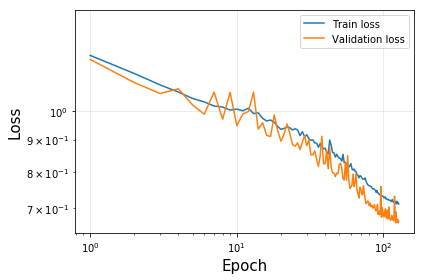

In [42]:
plt.plot(train.epoch, train.loss, label='Train loss')
plt.plot(train.epoch, train.val_loss, label='Validation loss')
plt.yscale('log'); plt.xscale('log')
plt.xlabel('Epoch', fontsize=15); plt.ylabel('Loss', fontsize=15)
plt.legend(loc='best')
plt.grid(lw=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

Loading trained weight and compiling the model

In [23]:
model.load_weights(weights_path)
model.compile(optimizer=optimizer, loss='mse',  sample_weight_mode='temporal')

Getting the encoded features and the decoded light curves

In [43]:
encode_model = Model(input=model.input, output=model.get_layer('encoding').output)
decode_model = Model(input=model.input, output=model.output)
encoding = encode_model.predict({'main_input': X_sim, 'aux_input': np.delete(X_sim, 1, axis=2)})
decoding = decode_model.predict({'main_input': X_sim, 'aux_input': np.delete(X_sim, 1, axis=2)})

/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("en...)`
  """Entry point for launching an IPython kernel.
/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ti...)`
  


In [44]:
encoding_train = encoding[0:int(0.8*len(X_sim_list))]
encoding_val = encoding[int(0.8*len(X_sim_list)):len(X_sim_list)]
decoding_train = decoding[0:int(0.8*len(X_sim_list))]
decoding_val = decoding[int(0.8*len(X_sim_list)):len(X_sim_list)]
X_raw_train = X_sim_raw[0:int(0.8*len(X_sim_list))]
X_raw_val = X_sim_raw[int(0.8*len(X_sim_list)):len(X_sim_list)]
X_train = X_sim[0:int(0.8*len(X_sim_list))]
X_val = X_sim[int(0.8*len(X_sim_list)):len(X_sim_list)]
scales_train = scales[0:int(0.8*len(X_sim_list))]
scales_val = scales[int(0.8*len(X_sim_list)):len(X_sim_list)]
means_train = means[0:int(0.8*len(X_sim_list))]
means_val = means[int(0.8*len(X_sim_list)):len(X_sim_list)]

### Distribution of the reduced chi-square

In [48]:
def calc_redchisq(x, x_pred, weight):
    mask =  (~np.isnan(weight))
    out = np.sum(((x[mask]-x_pred[mask])*weight[mask])**2)/len(weight[mask])
    return out

RedChiSq = []
print('Caluculating reduced chi-square for each source')
for m in range(0, len(X_sim_raw)):
    if m%100 == 0:
        print('.', end='')
    RedChiSq.append(calc_redchisq(X_sim[m][:,1]*scales[m]+means[m], np.squeeze(decoding[m]*scales[m]+means[m]), 1/X_sim_raw[m][:,2]))

Caluculating reduced chi-square for each source
.......................................................................................................................................................................................................................................................................................................................................................................................................................................

In [50]:
RedChiSq_train = RedChiSq[0:int(0.8*len(X_sim_list))]
RedChiSq_val = RedChiSq[int(0.8*len(X_sim_list)):len(X_sim_list)]

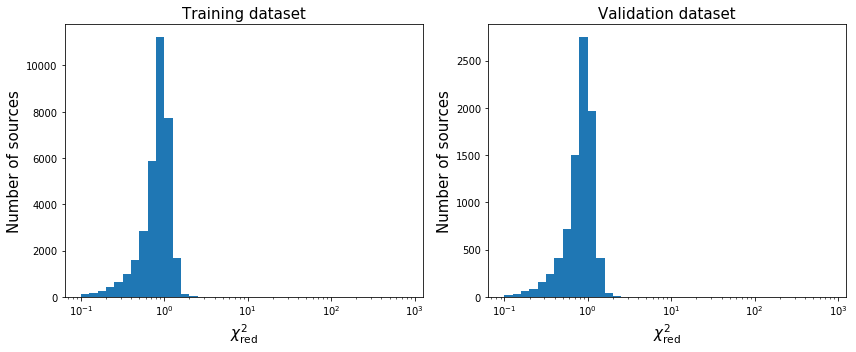

In [51]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(np.array(RedChiSq_train)[~np.isnan(RedChiSq_train)], 
         bins=10**np.arange(-1, 3, 0.1))
plt.xscale('log')
plt.xlabel(r'$\chi_{{\rm red}}^2$', fontsize=15)
plt.ylabel('Number of sources', fontsize=15)
plt.title('Training dataset', fontsize=15)
plt.tight_layout()
plt.savefig('Catalina_chi_hist.pdf', pad_inches=0.5)

plt.subplot(1,2,2)
plt.hist(np.array(RedChiSq_val)[~np.isnan(RedChiSq_val)], 
         bins=10**np.arange(-1, 3, 0.1))
plt.xscale('log')
plt.xlabel(r'$\chi_{{\rm red}}^2$', fontsize=15)
plt.ylabel('Number of sources', fontsize=15)
plt.title('Validation dataset', fontsize=15)
plt.tight_layout()
plt.savefig('Catalina_chi_hist.pdf', pad_inches=0.5)

plt.tight_layout()
plt.show()

In [54]:
from sklearn.ensemble import RandomForestRegressor

In [55]:
regr = RandomForestRegressor(n_estimators=100, n_jobs=-1)

In [57]:
tau_train = tau_list[0:int(0.8*len(tau_list))]
tau_val = tau_list[int(0.8*len(tau_list)):len(tau_list)]
sigma_train = sigma_list[0:int(0.8*len(sigma_list))]
sigma_val = sigma_list[int(0.8*len(sigma_list)):len(sigma_list)]

In [58]:
regr.fit(encoding_train, np.log10(tau_train))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

(2, 4)

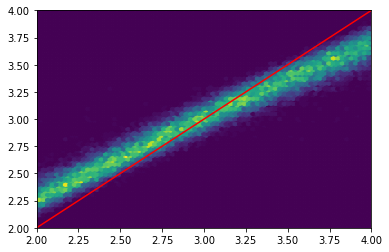

In [59]:
plt.hexbin(np.log10(tau_train), regr.predict(encoding_train), extent=[2,4,2,4], gridsize=75)
plt.plot([0, 4], [0, 4], color='red')
plt.xlim(2, 4)
plt.ylim(2, 4)
#plt.xscale('log')
#plt.yscale('log')

(2, 4)

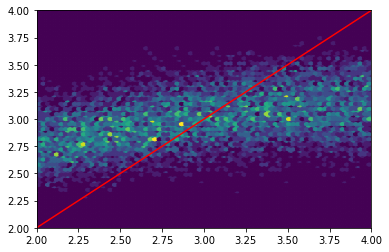

In [60]:
plt.hexbin(np.log10(tau_val), regr.predict(encoding_val), extent=[2,4,2,4], gridsize=75)
plt.plot([0, 4], [0, 4], color='red')
plt.xlim(2, 4)
plt.ylim(2, 4)

In [61]:
regr.fit(encoding_train, np.log10(sigma_train))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

(-2.5, -1.5)

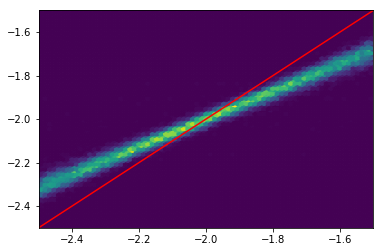

In [65]:
plt.hexbin(np.log10(sigma_train), regr.predict(encoding_train), extent=[-2.5,-1.5,-2.5,-1.5], gridsize=75)
plt.plot([-5, 0], [-5, 0], color='red')
plt.xlim(-2.5, -1.5)
plt.ylim(-2.5, -1.5)

(-2.5, -1.5)

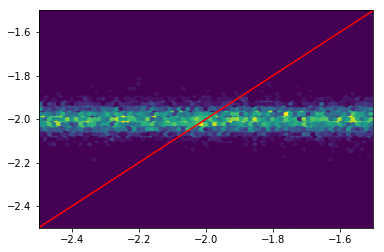

In [66]:
plt.hexbin(np.log10(sigma_val), regr.predict(encoding_val), extent=[-2.5,-1.5,-2.5,-1.5], gridsize=75)
plt.plot([-5, 0], [-5, 0], color='red')
plt.xlim(-2.5, -1.5)
plt.ylim(-2.5, -1.5)